In [4]:
import pyspark as ps
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType, FloatType, IntegerType, ArrayType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import CountVectorizer, Tokenizer, HashingTF, StandardScaler, Normalizer
from pyspark.ml.feature import StopWordsRemover
import re
import matplotlib.pyplot as plt
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import pandas as pd
from nltk.util import skipgrams
from itertools import chain

In [5]:
spark = (
    ps.sql.SparkSession.builder
    .master("local[4]")
    .appName("project1")
    .getOrCreate()
)

sc = spark.sparkContext

In [6]:
df = spark.read.json("42_users.json")


In [7]:
new_df = df.groupby('author').agg(F.count('body'))
authors = new_df.filter(new_df['count(body)']>500).select('author')

In [8]:
filtered_df = authors.join(df, ['author'], 'left')
filtered_df.show()

+--------------------+--------------------+
|              author|                body|
+--------------------+--------------------+
|dntletmygfknowimhere|                   A|
|dntletmygfknowimhere|I sold him for Co...|
|dntletmygfknowimhere|That same way, bu...|
|dntletmygfknowimhere|          Everyone..|
|dntletmygfknowimhere|                   A|
|dntletmygfknowimhere|I personally like...|
|dntletmygfknowimhere|Why did you hold ...|
|dntletmygfknowimhere|Everything is eit...|
|dntletmygfknowimhere|You don’t ride do...|
|dntletmygfknowimhere|Quickie. 

Russel...|
|dntletmygfknowimhere|             Goodbye|
|dntletmygfknowimhere|Username doesn’t ...|
|dntletmygfknowimhere|          Maybe 299%|
|dntletmygfknowimhere|That’s true. My t...|
|dntletmygfknowimhere|Breaking new: chi...|
|dntletmygfknowimhere|That’s what I’ve ...|
|dntletmygfknowimhere|                   V|
|dntletmygfknowimhere|There’s little on...|
|dntletmygfknowimhere|                   @|
|dntletmygfknowimhere|          

In [9]:
df1, df2 = filtered_df.randomSplit([0.5, 0.5])

In [10]:
df2.groupby('author').agg(F.count('body')).show()

+--------------------+-----------+
|              author|count(body)|
+--------------------+-----------+
|dntletmygfknowimhere|        328|
|            darkhorn|        517|
|         truballa030|        580|
|     melissastandard|        313|
|              Yaglis|       1482|
|           Macklebro|       1309|
|         DuckyDawg55|        725|
|          killnik420|        807|
|NoYeezyInYourSerrano|        377|
|          Colin03129|        377|
|              nowake|        979|
| shelbyamonkeysuncle|        554|
|     jl_theprofessor|       2671|
|   myKidsLike2Scream|        633|
|             a_frayn|        996|
|         stuntman628|        304|
|   DankDungeonDelver|        564|
|       QuoteMasterLT|       1571|
|     alreadypiecrust|       1452|
|     TheOddScientist|       1550|
+--------------------+-----------+
only showing top 20 rows



In [11]:
df1.groupby('author').agg(F.count('body')).show()

+--------------------+-----------+
|              author|count(body)|
+--------------------+-----------+
|dntletmygfknowimhere|        310|
|            darkhorn|        528|
|         truballa030|        547|
|     melissastandard|        282|
|              Yaglis|       1510|
|           Macklebro|       1343|
|         DuckyDawg55|        739|
|          killnik420|        814|
|NoYeezyInYourSerrano|        354|
|          Colin03129|        379|
|              nowake|        989|
| shelbyamonkeysuncle|        569|
|     jl_theprofessor|       2673|
|   myKidsLike2Scream|        635|
|             a_frayn|       1089|
|         stuntman628|        298|
|   DankDungeonDelver|        554|
|       QuoteMasterLT|       1554|
|     alreadypiecrust|       1474|
|     TheOddScientist|       1545|
+--------------------+-----------+
only showing top 20 rows



In [12]:
comments1 = df1.groupBy("author").agg(F.collect_list("body"))
join_comments_udf = udf(lambda x: ' '.join(x), StringType())
df1_join_comments = comments1.withColumn('corpus', join_comments_udf(comments1['collect_list(body)']))

In [13]:
def count_links(s):
    try:
        num_links = len(re.findall(r'\(http.+\)', s)[0].split(')('))
        return num_links
    except:
        return 0
count_links_udf = udf(count_links, IntegerType())
df_count_links1 = df1_join_comments.withColumn(
    'link_count', count_links_udf(df1_join_comments['corpus']))
df_count_links1.show(3)

+--------------------+--------------------+--------------------+----------+
|              author|  collect_list(body)|              corpus|link_count|
+--------------------+--------------------+--------------------+----------+
|dntletmygfknowimhere|[ Got the same on...| Got the same one...|         1|
|            darkhorn|["Because you dow...|"Because you down...|         1|
|         truballa030|["Drew" Bledsoe, ...|"Drew" Bledsoe "T...|         0|
+--------------------+--------------------+--------------------+----------+
only showing top 3 rows



In [14]:
def drop_links(s):
    return re.sub(r'\(http.+\)', '', s)
drop_links_udf = udf(drop_links, StringType())
df_drop_links1 = df_count_links1.withColumn('corpus', drop_links_udf(df_count_links1['corpus']))

In [15]:
df_drop_links1.show(5)

+--------------------+--------------------+--------------------+----------+
|              author|  collect_list(body)|              corpus|link_count|
+--------------------+--------------------+--------------------+----------+
|dntletmygfknowimhere|[ Got the same on...| Got the same one...|         1|
|            darkhorn|["Because you dow...|"Because you down...|         1|
|         truballa030|["Drew" Bledsoe, ...|"Drew" Bledsoe "T...|         0|
|     melissastandard|[8+ hours of sun ...|8+ hours of sun  ...|         0|
|              Yaglis|["*Come at me bro...|"*Come at me bro!...|         1|
+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [16]:
def tokenize(s):
    s = s.lower()
    token = TweetTokenizer()
    return token.tokenize(s)

tokenize_udf = udf(tokenize, ArrayType(StringType()))
df_tokens1 = df_drop_links1.withColumn('tokens', tokenize_udf(df_drop_links1['corpus']))

In [17]:
def find_words(s):
    return [i for i in s if i.isalpha()]
        
find_words_udf = udf(find_words, ArrayType(StringType()))
df_find_words1 = df_tokens1.withColumn('words', find_words_udf(df_tokens1['tokens']))

In [18]:
def word_length(words):
    return [len(word) for word in words]

word_length_udf = udf(word_length, ArrayType(IntegerType()))
word_length_df1 = df_find_words1.withColumn('word_lengths', word_length_udf(df_find_words1['words']))
total_words_udf = udf(lambda x: len(x), IntegerType())
total_words_df1 = word_length_df1.withColumn('total_words', total_words_udf(word_length_df1['words']))

In [19]:
def pos_tagger(s):
    return [i[1] for i in nltk.pos_tag(s)]

In [20]:
pos_tagger_udf = udf(pos_tagger, ArrayType(StringType()))
df_pos_tagger1 = total_words_df1.withColumn('POS', pos_tagger_udf(total_words_df1['tokens']))

In [21]:
df_pos_tagger1.show(3)

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+-----------+--------------------+
|              author|  collect_list(body)|              corpus|link_count|              tokens|               words|        word_lengths|total_words|                 POS|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+-----------+--------------------+
|dntletmygfknowimhere|[ Got the same on...| Got the same one...|         1|[got, the, same, ...|[got, the, same, ...|[3, 3, 4, 3, 9, 2...|       6937|[VBD, DT, JJ, NN,...|
|            darkhorn|["Because you dow...|"Because you down...|         1|[", because, you,...|[because, you, do...|[7, 3, 6, 2, 5, 3...|      10897|[NN, IN, PRP, VBD...|
|         truballa030|["Drew" Bledsoe, ...|"Drew" Bledsoe "T...|         0|[", drew, ", bled...|[drew, bledsoe, t...|[4, 7, 5, 4, 5, 7...|  

In [22]:
def skip_grams(s):
    grams = []
    for i in skipgrams(s,2,2):
        grams.append(str(i))
    return grams

In [23]:
skip_grams_udf = udf(skip_grams, ArrayType(StringType()))
df_skip_grams1 = df_pos_tagger1.withColumn('skip_grams', skip_grams_udf(df_pos_tagger1['POS']))

In [24]:
import csv

with open('skip_grams.csv', 'r') as f:
  reader = csv.reader(f)
  com_skips = list(reader)

In [25]:
skips = com_skips[0]
skips

["('NN', 'NN')",
 "('DT', 'NN')",
 "('JJ', 'NN')",
 "('IN', 'NN')",
 "('NN', 'IN')",
 "('NN', '.')",
 "('IN', 'DT')",
 "('NN', 'JJ')",
 "('NN', 'DT')",
 "('.', 'NN')",
 "('NN', 'RB')",
 "('DT', 'JJ')",
 "('NN', ',')",
 "('IN', 'JJ')",
 "('VB', 'NN')",
 "('DT', 'IN')",
 "('JJ', 'IN')",
 "('NN', 'PRP')",
 "('NN', 'CC')",
 "('NN', 'VB')",
 "('NN', 'VBZ')",
 "('JJ', '.')",
 "('RB', 'NN')",
 "('NN', 'VBD')",
 "('NN', 'NNS')",
 "('.', 'JJ')",
 "('RB', 'JJ')",
 "('RB', 'IN')",
 "('IN', 'IN')",
 "('JJ', 'JJ')",
 "('JJ', 'NNS')",
 "('TO', 'VB')",
 "('VB', 'DT')",
 "('NN', 'VBP')",
 "('IN', '.')",
 "('VB', 'IN')",
 "('IN', 'NNS')",
 "('IN', 'PRP')",
 "('NNS', 'IN')",
 "('DT', '.')",
 "('.', 'DT')",
 "('.', 'RB')",
 "('NNS', 'NN')",
 "('VBP', 'NN')",
 "('RB', 'DT')",
 "('CC', 'NN')",
 "(',', 'NN')",
 "('PRP$', 'NN')",
 "('.', 'IN')",
 "('VB', 'JJ')",
 "('PRP', 'VBP')",
 "('PRP', 'VB')",
 "('DT', 'NNS')",
 "('.', 'VB')",
 "('RB', 'RB')",
 "('JJ', 'DT')",
 "('.', 'PRP')",
 "('RB', '.')",
 "('VBD', 

In [26]:
def skip_grams_filter(s):
    return [i for i in s if i in skips]
com_skips_udf = udf(skip_grams_filter, ArrayType(StringType()))
df_com_skips1 = df_skip_grams1.withColumn('com_skips', com_skips_udf(df_skip_grams1['skip_grams']))




In [27]:
stops = stopwords.words('english')
x = [i.split("'")for i in stops]
stops = [i[0] for i in x]
stops = list(set(stops))
slang_stops = ['gonna', 'coulda', 'shoulda',
               'lotta', 'lots', 'oughta', 'gotta', 'ain', 'sorta', 'kinda', 'yeah', 'whatever', 'cuz', 'ya', 'haha', 'lol', 'eh']
puncts = ['!', ':', '...', '.', '%', '$', "'", '"', ';']
formattings = ['##', '__', '_', '    ', '*', '**']

In [28]:
stops.extend(slang_stops)

In [29]:
stops.extend(puncts)

In [30]:
stops.extend(formattings)

In [31]:
stops.extend(skips)

In [32]:
def stop_words_filter(s):
    return [i for i in s if i in stops]

In [33]:
stop_words_udf = udf(stop_words_filter, ArrayType(StringType()))
df_stop_words1 = df_com_skips1.withColumn('stop_words', stop_words_udf(df_com_skips1['tokens']))

In [34]:
def concat(type):
    def concat_(*args):
        return list(chain.from_iterable((arg if arg else [] for arg in args)))
    return udf(concat_, ArrayType(type))

In [35]:
concat_arrays_udf = concat(StringType())
df_all_words1 = df_stop_words1.select("author", concat_arrays_udf("stop_words", "com_skips"))

In [36]:
hashingTF = HashingTF(numFeatures=285, inputCol='concat_(stop_words, com_skips)', outputCol='features')
tf1 = hashingTF.transform(df_all_words1)

In [37]:
tf_norm1 = Normalizer(inputCol="features", outputCol="features_norm", p=1).transform(tf1)

In [38]:
stdscaler = StandardScaler(inputCol='features_norm', outputCol='scaled', withMean=True)
scale_fit1 = stdscaler.fit(tf_norm1)
scaled1 = scale_fit1.transform(tf_norm1)

In [39]:
comments2 = df2.groupBy("author").agg(F.collect_list("body"))
join_comments_udf = udf(lambda x: ' '.join(x), StringType())
df2_join_comments = comments2.withColumn('corpus', join_comments_udf(comments2['collect_list(body)']))

In [40]:
df_count_links2 = df2_join_comments.withColumn(
    'link_count', count_links_udf(df2_join_comments['corpus']))

In [41]:
df_drop_links2 = df_count_links2.withColumn('corpus', drop_links_udf(df_count_links2['corpus']))

In [42]:
df_tokens2 = df_drop_links2.withColumn('tokens', tokenize_udf(df_drop_links2['corpus']))

In [43]:
pos_tagger_udf = udf(pos_tagger, ArrayType(StringType()))
df_pos_tagger2 = df_tokens2.withColumn('POS', pos_tagger_udf(df_tokens2['tokens']))

In [44]:
skip_grams_udf = udf(skip_grams, ArrayType(StringType()))
df_skip_grams2 = df_pos_tagger2.withColumn('skip_grams', skip_grams_udf(df_pos_tagger2['POS']))

In [45]:
com_skips_udf = udf(skip_grams_filter, ArrayType(StringType()))
df_com_skips2 = df_skip_grams2.withColumn('com_skips', com_skips_udf(df_skip_grams2['skip_grams']))


In [46]:
df_stop_words2 = df_com_skips2.withColumn('stop_words', stop_words_udf(df_com_skips2['tokens']))

In [47]:
df_all_words2 = df_stop_words2.select("author", concat_arrays_udf("stop_words", "com_skips"))

In [48]:
tf2 = hashingTF.transform(df_all_words2)

In [49]:
tf_norm2 = Normalizer(inputCol="features", outputCol="features_norm", p=1).transform(tf2)

In [50]:
scaled2 = scale_fit1.transform(tf_norm2)

In [51]:
sims1 = scaled1.select('author','scaled')
sims2 = scaled2.select('author','scaled')
similarities = {}
for i in sims1.rdd.collect():
    similarity = {}
    auth1, vec1 = i[0], i[1]
    for j in sims2.rdd.collect():
        auth2, vec2 = j[0], j[1]
        cos = vec1.dot(vec2) / (vec2.norm(2)*vec1.norm(2))
        similarity [auth2] = cos
    similarities [auth1] = similarity

In [52]:
pdf = pd.DataFrame(similarities)

In [53]:
cols = pdf.columns
mask = []
for i in pdf:
    mask.append(i == pdf.index)
mask = np.array(mask)
mask = mask.T

In [54]:
matches = pdf.values[mask]
non_matches = pdf.values[~mask]

In [55]:
non_mas = non_matches.reshape(27,-1)
non_mas_max = np.max(non_mas, axis=1)
np.sum(matches > non_mas_max) / len(matches)

1.0

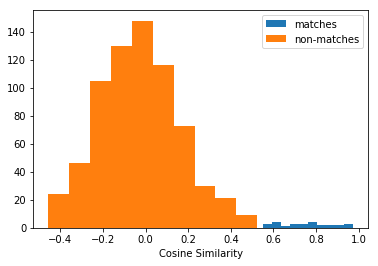

In [64]:
plt.hist(matches , label='matches')
plt.hist(non_matches, label='non-matches')
plt.xlabel('Cosine Similarity')
plt.legend()
plt.savefig('match_distro.png')

(array([1., 2., 3., 5., 7., 3., 1., 5.]),
 array([0.147423  , 0.20715399, 0.26688498, 0.32661596, 0.38634695,
        0.44607793, 0.50580892, 0.5655399 , 0.62527089]),
 <a list of 8 Patch objects>)

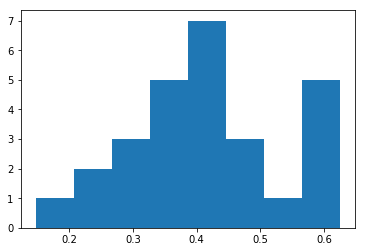

In [57]:
plt.hist(matches - non_mas_max, bins=8)

In [61]:
import csv

In [68]:
with open('matches.csv', 'a') as f:
    wr = csv.writer(f, quoting=csv.QUOTE_ALL)
    wr.writerow(matches)
    

In [69]:
with open('nonmatches.csv', 'a') as f:
    wr = csv.writer(f, quoting=csv.QUOTE_ALL)
    wr.writerow(non_matches)

In [15]:
# MCCC1 = total_words_df1.select('author', 'word_lengths', 'total_words')
# word_freqs1 = {}
# for i in MCCC1.rdd.collect():
#     x = []
#     y = []
#     for k, v in (dict(nltk.FreqDist(i[1]))).items():
#         x.append(k)
#         y.append(v / i[2])
#     idx = np.argsort(x)[1:12]
#     z = np.array(y)[idx]
#     plt.plot(range(1,12), z)
#     word_freqs1[i[0]] = z

In [16]:
# word_freqs1

In [39]:
def count_links(s):
    try:
        num_links = len(re.findall(r'\(http.+\)', s)[0].split(')('))
        return num_links
    except:
        return 0
count_links_udf = udf(count_links, IntegerType())
df_count_links2 = df2_join_comments.withColumn(
    'link_count', count_links_udf(df2_join_comments['corpus']))


In [40]:
def drop_links(s):
    return re.sub(r'\(http.+\)', '', s)
drop_links_udf = udf(drop_links, StringType())
df_drop_links2 = df_count_links2.withColumn('corpus', drop_links_udf(df_count_links2['corpus']))

In [41]:
def tokenize(s):
    s = s.lower()
    token = TweetTokenizer()
    return token.tokenize(s)

tokenize_udf = udf(tokenize, ArrayType(StringType()))
df_tokens2 = df_drop_links2.withColumn('tokens', tokenize_udf(df_drop_links2['corpus']))

In [42]:
def find_words(s):
    return [i for i in s if i.isalpha()]
        
find_words_udf = udf(find_words, ArrayType(StringType()))
df_find_words2 = df_tokens2.withColumn('words', find_words_udf(df_tokens2['tokens']))

In [43]:
def word_length(words):
    return [len(word) for word in words]

word_length_udf = udf(word_length, ArrayType(IntegerType()))
word_length_df2 = df_find_words2.withColumn('word_lengths', word_length_udf(df_find_words2['words']))
total_words_udf = udf(lambda x: len(x), IntegerType())
total_words_df2 = word_length_df2.withColumn('total_words', total_words_udf(word_length_df2['words']))

In [44]:
total_words_df2.show(5)

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+-----------+
|              author|  collect_list(body)|              corpus|link_count|              tokens|               words|        word_lengths|total_words|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+-----------+
|dntletmygfknowimhere|[11-13 targets a ...|11-13 targets a g...|         1|[11-13, targets, ...|[targets, a, game...|[7, 1, 4, 12, 2, ...|       7108|
|           Ashaman21|["Not talking abo...|"Not talking abou...|         0|[", not, talking,...|[not, talking, ab...|[3, 7, 5, 3, 12, ...|       3400|
|            darkhorn|["Because you dow...|"Because you down...|         1|[", because, you,...|[because, you, do...|[7, 3, 6, 2, 5, 3...|      11842|
|         truballa030|[&gt; Darrelle Re...|&gt; Darrelle Rev...|         1|[>, darrelle, rev..

In [24]:
# MCCC2 = total_words_df2.select('author', 'word_lengths', 'total_words')
# word_freqs2 = {}
# for i in MCCC2.rdd.collect():
#     x = []
#     y = []
#     for k, v in (dict(nltk.FreqDist(i[1]))).items():
#         x.append(k)
#         y.append(v / i[2])
#     idx = np.argsort(x)[1:12]
#     z = np.array(y)[idx]
#     plt.plot(range(1,12), z)
#     word_freqs2[i[0]] = z

In [25]:
# word_freqs1

In [26]:
# #find RMSE for each of the users
# word_lengths = {}
# for key, value in word_freqs1.items():
#     error_values = {}
#     for k, v in word_freqs2.items():
#         rmse = np.mean(np.sqrt((v-value)**2))
#         error_values[k] = rmse
#     word_lengths[key] = error_values

In [27]:
# word_lengths

In [28]:
# import pandas as pd

In [29]:
# df = pd.DataFrame(word_lengths)

In [30]:
# ax = df.plot(kind='bar', figsize=(16,8), title='RMSE of User Word Length Choices')
# fig = ax.get_figure()
# fig.savefig('word_length_errors.png')


In [31]:
# fig, ax = plt.subplots(2,1,figsize=(10,12))
# for key, value in word_freqs1.items():
#     ax[0].plot(range(1,12), value, label=key)
# ax[0].set_ylabel('% of Total Words')
# ax[0].set_xlabel('Word Length')
# ax[0].set_title('Word Choice Frequencies: Subset 1')
# ax[0].legend()
# for key, value in word_freqs2.items():
#     ax[1].plot(range(1,12), value, label=key)
# ax[1].set_ylabel('% of Total Words')
# ax[1].set_xlabel('Word Length')
# ax[1].set_title('Word Choice Frequencies: Subset 2')
# ax[1].legend()
# fig.savefig('word_lengths.png', bbox_inches='tight')

In [32]:
stops = stopwords.words('english')
x = [i.split("'")for i in stops]
stops = [i[0] for i in x]
stops = list(set(stops))
slang_stops = ['gonna', 'coulda', 'shoulda',
               'lotta', 'lots', 'oughta', 'gotta', 'ain', 'sorta', 'kinda', 'yeah', 'whatever', 'cuz', 'ya', 'haha', 'lol', 'eh']
puncts = ['!', ':', '...', '.', '%', '$', "'", '"', ';']
formattings = ['##', '__', '_', '    ', '*', '**']


In [33]:
stops.extend(slang_stops)

In [34]:
stops.extend(puncts)

In [35]:
stops.extend(formattings)

In [36]:
len(stops)

185

In [37]:
def stop_words_filter(s):
    return [i for i in s if i in stops]


In [38]:
stop_words_udf = udf(stop_words_filter, ArrayType(StringType()))
df_stop_words1 = total_words_df1.withColumn('stop_words', stop_words_udf(total_words_df1['tokens']))


In [39]:
hashingTF = HashingTF(numFeatures=179, inputCol='stop_words', outputCol='features')
tf1 = hashingTF.transform(df_stop_words1)

In [40]:
tf_norm1 = Normalizer(inputCol="features", outputCol="features_norm", p=1).transform(tf1)

In [41]:
stdscaler = StandardScaler(inputCol='features_norm', outputCol='scaled', withMean=True)
scale_fit1 = stdscaler.fit(tf_norm1)
scaled1 = scale_fit1.transform(tf_norm1)

In [42]:
scaled1.show(5)

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+
|              author|  collect_list(body)|              corpus|link_count|              tokens|               words|        word_lengths|total_words|          stop_words|            features|       features_norm|              scaled|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+
|dntletmygfknowimhere|[1-2, 10/11/15, 1...|1-2 10/11/15 11-1...|         1|[1-2, 10/11, /, 1...|[targets, a, game...|[7, 1, 4, 12, 2, ...|       7234|[a, is, ., i, wha...|(179,[0,5,7,8,9,1...|(179,[0,5,7,8,9,1...|[-0.1861533446362...|
|           Ashaman21|["Not talking abo...|"Not talking abou

In [43]:
stop_words_udf = udf(stop_words_filter, ArrayType(StringType()))
df_stop_words2 = total_words_df2.withColumn('stop_words', stop_words_udf(total_words_df2['tokens']))


In [44]:
hashingTF = HashingTF(numFeatures=179, inputCol='stop_words', outputCol='features')
tf2 = hashingTF.transform(df_stop_words2)

In [45]:
tf_norm2 = Normalizer(inputCol="features", outputCol="features_norm", p=1).transform(tf2)

In [46]:
stdscaler = StandardScaler(inputCol='features_norm', outputCol='scaled', withMean=True)
scale_fit2 = stdscaler.fit(tf_norm2)
scaled2 = scale_fit2.transform(tf_norm2)

In [47]:
scaled2.show(5)

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+
|              author|  collect_list(body)|              corpus|link_count|              tokens|               words|        word_lengths|total_words|          stop_words|            features|       features_norm|              scaled|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+
|dntletmygfknowimhere|[/, 1 karma. 9 ye...|/ 1 karma. 9 year...|         1|[/, 1, karma, ., ...|[karma, years, da...|[5, 5, 4, 1, 6, 1...|       6720|[., ., a, all, th...|(179,[0,5,7,8,9,1...|(179,[0,5,7,8,9,1...|[0.05805348912460...|
|           Ashaman21|[$10?  Aren't the...|$10?  Aren't they

In [48]:
sims1 = scaled1.select('author','scaled')
sims2 = scaled2.select('author','scaled')
similarities = {}
for i in sims1.rdd.collect():
    similarity = {}
    auth1, vec1 = i[0], i[1]
    for j in sims2.rdd.collect():
        auth2, vec2 = j[0], j[1]
        cos = vec1.dot(vec2) / (vec2.norm(2)*vec1.norm(2))
        similarity [auth2] = cos
    similarities [auth1] = similarity
    
        
    

In [50]:
pdf = pd.DataFrame(similarities)

In [51]:
cols = pdf.columns
mask = []
for i in pdf:
    mask.append(i == pdf.index)
mask = np.array(mask)
mask = mask.T

In [52]:
pdf

,dntletmygfknowimhere,Ashaman21,darkhorn,truballa030,melissastandard,Yaglis,Macklebro,DuckyDawg55,killnik420,NoYeezyInYourSerrano,...,glackbuy99,AevnNoram,wahmeiman1975,Flashy_Gardener,Gay_Black_Atheist,kawow02,dvaldez0919,cocorazor,jessetmia,Jimmy2e
AevnNoram,-0.097932,-0.038870,0.001416,0.149221,-0.149164,0.063680,0.027135,-0.102060,-0.235987,-0.145421,...,-0.121178,0.695392,-0.015190,-0.079269,0.007729,-0.100473,-0.147875,-0.109408,-0.093517,0.020842
Ashaman21,-0.165408,0.246578,-0.068616,0.034913,-0.031076,-0.081990,0.021910,-0.148600,0.207720,0.039399,...,-0.067171,-0.174363,0.121517,-0.070957,0.163876,0.010027,0.013240,0.002931,0.129620,0.032462
Colin03129,-0.207165,0.088088,-0.025910,-0.138920,-0.104438,0.150664,-0.261085,-0.252467,-0.036224,0.068391,...,-0.022279,-0.125436,0.114725,0.000715,-0.059132,0.308662,-0.071668,-0.110783,0.084536,0.384408
DankDungeonDelver,-0.122641,-0.114316,-0.141943,-0.056200,-0.022564,0.245262,-0.264842,-0.101335,0.032233,-0.224168,...,-0.010482,0.029036,-0.111219,0.145534,-0.050935,-0.015748,-0.121626,0.049232,0.258758,-0.009962
DuckyDawg55,0.260492,-0.156622,-0.073401,0.067935,0.154867,0.010648,0.198523,0.653594,0.025110,-0.125271,...,-0.008995,-0.004239,-0.140664,-0.069674,0.025607,-0.189279,0.138388,0.206339,-0.026809,-0.151351
EmmettRapaportNBA,-0.204634,0.032419,0.216410,0.102948,-0.252053,0.138292,-0.036508,-0.159288,-0.263069,0.102228,...,0.053561,0.001222,0.315398,0.012474,0.212947,0.193072,-0.064351,-0.243341,0.032843,0.145931
Flashy_Gardener,-0.182525,-0.156859,-0.000881,-0.167916,0.172988,-0.007663,-0.210114,0.018969,0.074441,-0.216465,...,0.058770,0.056927,0.314691,0.882818,-0.153332,-0.009024,-0.035538,0.247204,0.139687,-0.014765
Gay_Black_Atheist,-0.184597,0.220668,-0.078874,0.018929,-0.157241,0.012497,0.095103,0.124301,-0.057723,0.171161,...,-0.121293,0.130341,0.097593,-0.190223,0.673280,0.127645,-0.019016,-0.146930,0.013438,-0.098373
GuiHarrison,-0.136393,-0.051547,-0.019046,0.037945,-0.034065,0.061313,-0.111662,-0.068740,0.243221,-0.061132,...,0.105808,0.066518,-0.185273,-0.050678,-0.004974,-0.035610,-0.231362,-0.010895,-0.017911,-0.053957
Jimmy2e,-0.206137,0.155319,0.184476,-0.235154,-0.140687,-0.013416,-0.277641,-0.234765,-0.084548,0.079485,...,-0.127731,0.001857,0.090390,-0.029601,-0.263151,0.127507,-0.221698,-0.026097,0.071015,0.594095


In [53]:
matches = pdf.values[mask]

In [54]:
non_matches = pdf.values[~mask]

(array([ 20., 102., 341., 453., 366., 233.,  90.,  26.,   7.,   2.]),
 array([-0.41638809, -0.31301256, -0.20963703, -0.10626149, -0.00288596,
         0.10048957,  0.2038651 ,  0.30724063,  0.41061616,  0.51399169,
         0.61736723]),
 <a list of 10 Patch objects>)

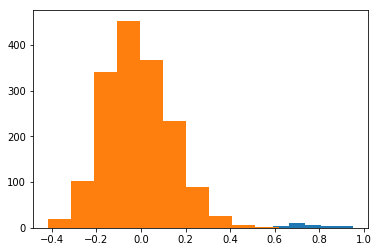

In [55]:
plt.hist(matches)
plt.hist(non_matches)

In [56]:
sample = pd.read_json('sample.json', lines=True)

In [58]:
non_mas = non_matches.reshape(41,-1)

In [65]:
non_mas_max = np.max(non_mas, axis=1)

In [68]:
np.sum(matches > non_mas_max) / len(matches)

0.9512195121951219